In [21]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [22]:
# Read in College Data CSV
college_data = pd.read_csv('college-records.csv')

In [23]:
college_data.head()

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,State
0,region,name,publicprivate,tuition,population,acceptance,ranking,geo,male2female,college-type,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownership,County,State
1,us-west,Stanford,Private,"$57,692","7,761",4.34%,6,Suburban,49 : 51,Research,...,-6.244466,-5.684776,-7.151565,-6.981125,-5.677183,-1.537808,2008.18996,Independent,Santa Clara,California
2,us-west,UC Berkeley,Public,"$43,980","32,143",17.50%,49,Urban,46 : 54,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Alameda,California
3,us-west,Santa Clara,Private,"$58,017","5,895",52.00%,NaN,Suburban,53 : 47,Catholic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Santa Clara,California
4,us-west,Caltech,Private,"$58,479",901,6.70%,2,Suburban,65 : 35,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,California


In [24]:
college_data.tail()

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,State
40,us-midwest,Kenyon,Private,"$63,310","1,662",36.50%,NaN,Rural,43 : 57,Research,...,3.012478,-2.512117,-3.643569,-3.592714,-2.955069,-0.473330,953.644406,independent,Knox,Ohio
41,us-midwest,Illinois Wesleyan,Private,"$52,512","2,090",45.20%,NaN,Urban,49 : 51,Research,...,-5.978340,-0.772456,-0.115412,-0.591196,2.197966,NaN,NaN,independent,McLean,Illinois
42,us-midwest,"University of Nevada, Reno",Public,"$24,680","20,194",88%,NaN,Rural,47 : 53,Research,...,-0.616725,-0.939728,-1.021639,-2.842037,1.678874,-0.365339,737.223329,independent,Washoe,Nevada
43,us-midwest,Urbana-Champaign,Public,"$17,138","7,665",59.70%,NaN,Urban,54 : 46,Research,...,-1.879008,-1.528325,-3.371316,-2.642117,-4.669182,-0.261031,524.582127,independent,Champaign,Illinois
44,us-midwest,University of Minnesota,Public,"$15,254","36,209",73.20%,NaN,Urban,45 : 55,Research,...,-2.840436,-2.218186,-3.918725,-2.057011,-1.747670,0.663542,-1343.133053,independent,Hennepin,Minnesota


In [25]:
election_data = pd.read_csv('elections_per.csv')
election_data.head()

,State,County,per_dem_2000,per_gop_2000,per_dem_2004,per_gop_2004,per_dem_2008,per_gop_2008,per_dem_2012,per_gop_2012,per_dem_2016,per_gop_2016,per_dem_2020,per_gop_2020
0,ALABAMA,AUTAUGA,0.287192,0.696943,0.236940,0.756735,0.257730,0.736136,0.265878,0.726183,0.237697,0.727666,0.270184,0.714368
1,ALABAMA,BALDWIN,0.247822,0.723654,0.225029,0.764152,0.238119,0.752595,0.215894,0.773583,0.193856,0.765457,0.224090,0.761714
2,ALABAMA,BARBOUR,0.499086,0.490236,0.448362,0.547369,0.489854,0.504385,0.513685,0.482231,0.465278,0.520967,0.457882,0.534512
3,ALABAMA,BIBB,0.381636,0.601746,0.274868,0.720000,0.265965,0.724433,0.261520,0.728266,0.212496,0.764032,0.206983,0.784263
4,ALABAMA,BLOUNT,0.276915,0.704779,0.183129,0.808501,0.145135,0.840195,0.123719,0.864659,0.084258,0.893348,0.095694,0.895716


In [30]:
def get_county_info(county, st):
    fd = False
    for index, rows in election_data.iterrows():
        metrics_yr = None
        if county == rows['County'] and st == rows['State']:
            metrics_yr = [rows['per_gop_2012'] - rows['per_dem_2012'],rows['per_gop_2016'] - rows['per_dem_2016'],rows['per_gop_2020'] - rows['per_dem_2020']]
            fd = True
            break

    if fd:
        return metrics_yr
    else:
        print("County Not Found")
        return None

# Scaling

Not sure if I am scaling everything correctly so far. Need confirmation that the Bipartisan API spits out values from -42 to +42, or if it is from -1 to 1. Either way, we might need to check to see that we are doing this step correctly due to suspicious values in the csv file.

Santa Clara California [-18.023810004835653, -21.895465312765715, -19.913122795070265]


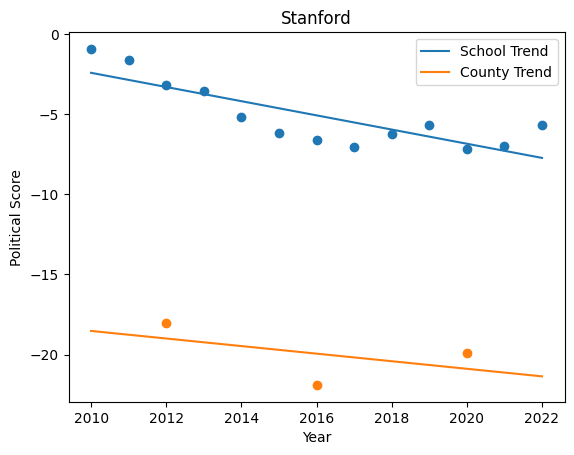

Alameda California [-25.49028443216747, -26.892181467065505, -26.253067902577]


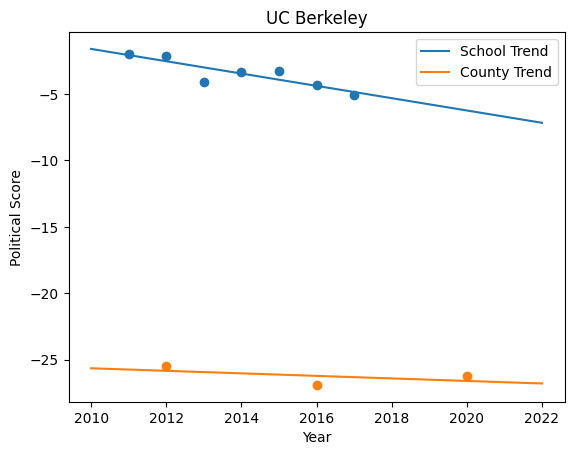

Los Angeles California [-17.58087459328087, -20.724431821430333, -18.54928224948252]


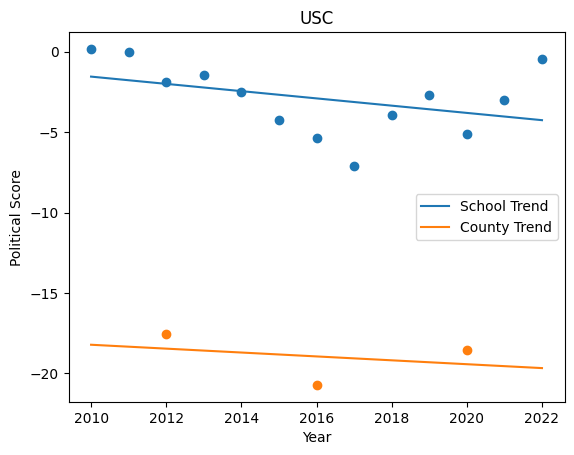

Los Angeles California [-17.58087459328087, -20.724431821430333, -18.54928224948252]


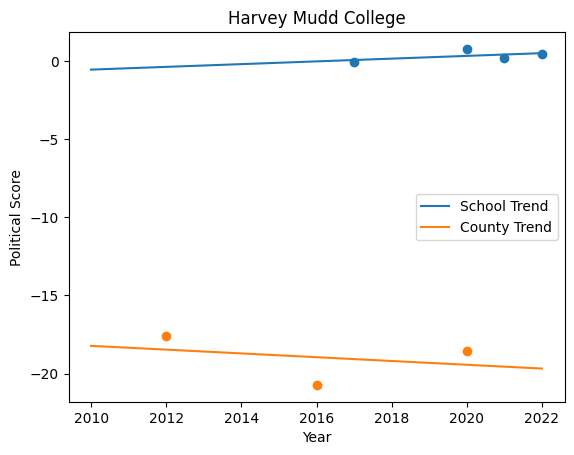

Los Angeles California [-17.58087459328087, -20.724431821430333, -18.54928224948252]


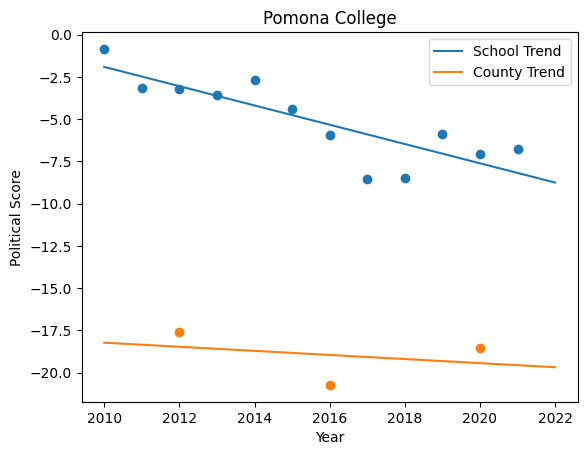

Utah Utah [33.00882884015189, 15.349564129408956, 17.252759544358405]


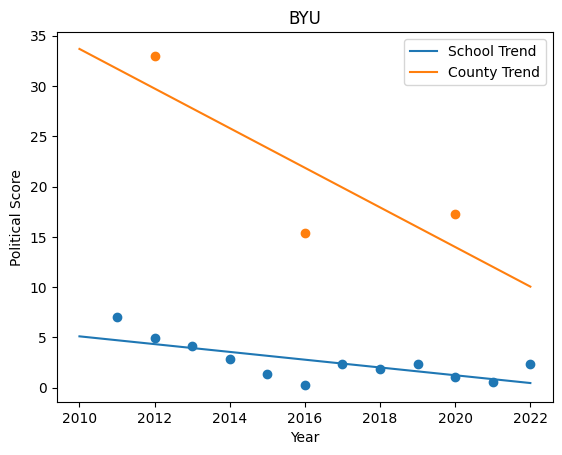

Middlesex Massachusetts [-11.387732208767419, -16.101105309003167, -18.853323241250582]


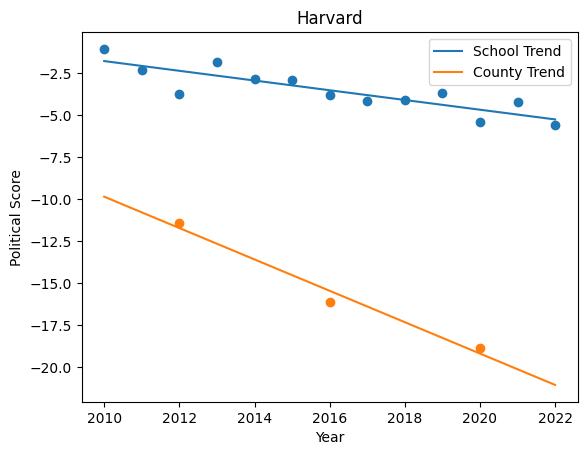

Delaware Pennsylvania [-8.96274740482124, -9.41717008105871, -11.256703391528804]


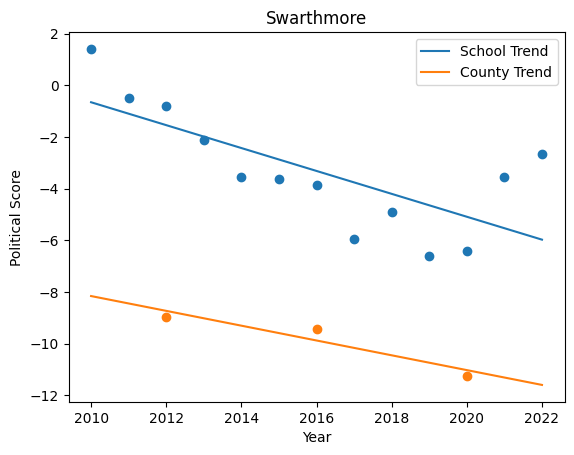

Norfolk Massachusetts [-6.399256148792667, -11.859741897327162, -15.124381449702845]


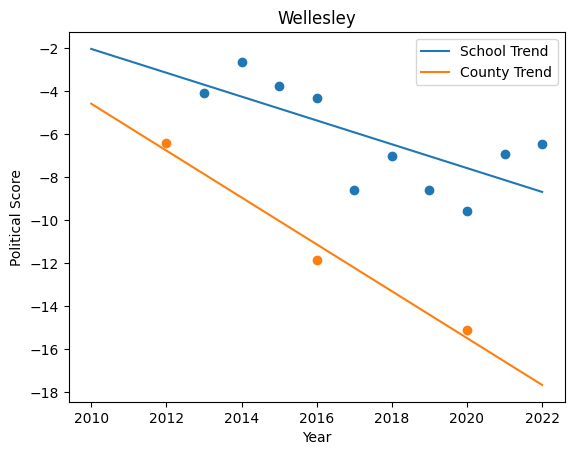

Grafton New Hampshire [-9.957269664328686, -7.794338847103136, -10.331505019765872]


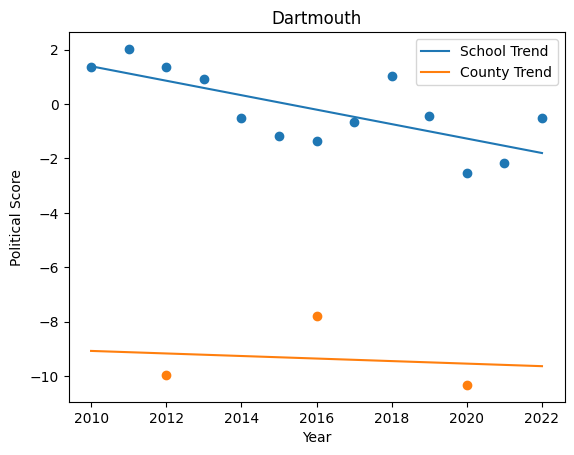

New York New York [-28.225790193205842, -32.27727490799195, -31.009060385497552]


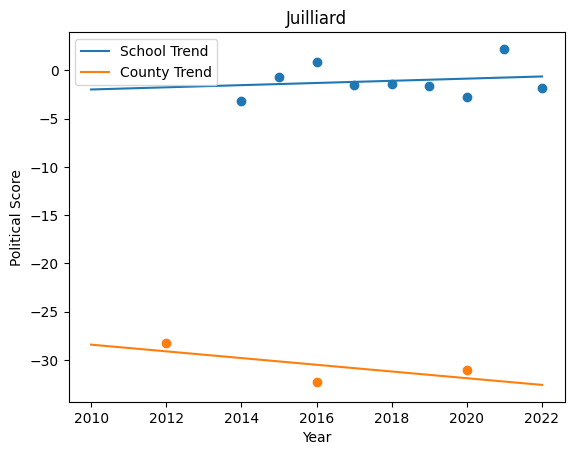

Providence Rhode Island [-14.666519314286038, -8.792525575762753, -9.621120267226285]


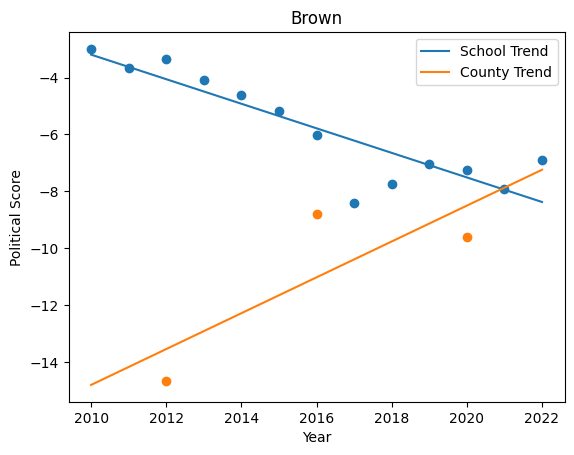

Middlesex Massachusetts [-11.387732208767419, -16.101105309003167, -18.853323241250582]


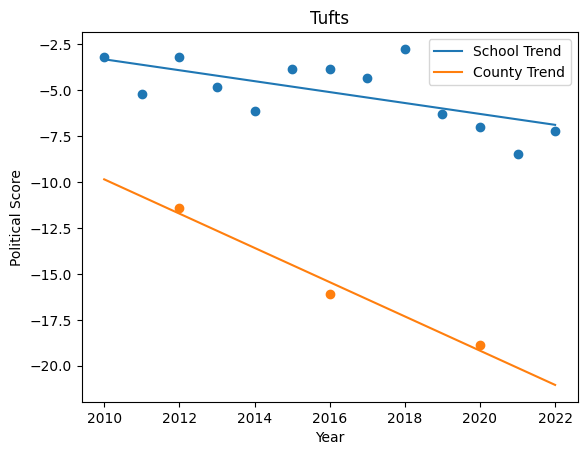

Middlesex Connecticut [-6.668677726702981, -3.075690557515381, -6.8518115277675165]


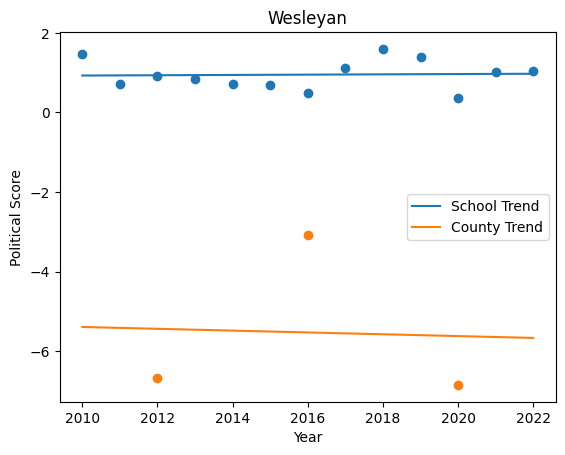

Addison Vermont [-16.542043541852575, -13.069413056029946, -15.829640433492706]


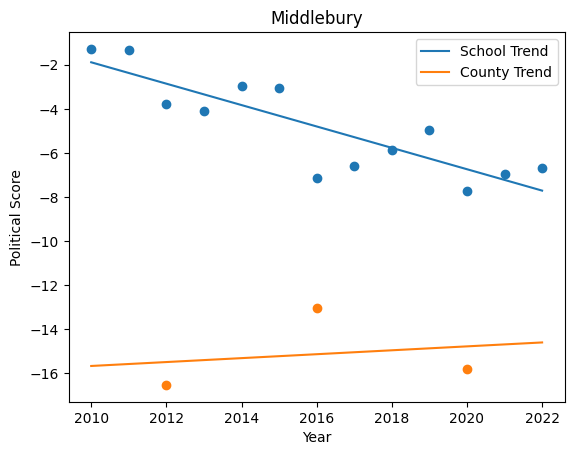

New York New York [-28.225790193205842, -32.27727490799195, -31.009060385497552]


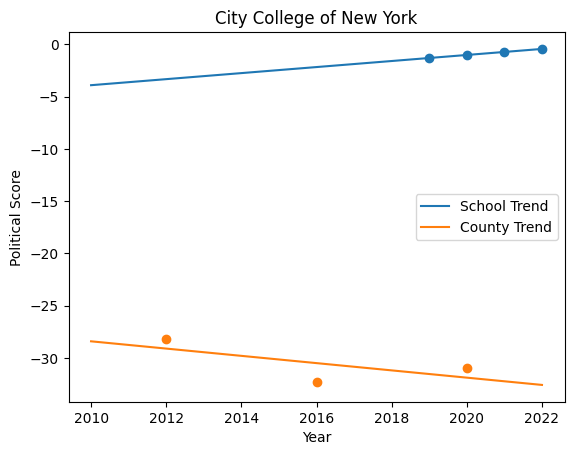

Orange New York [-3.8046335008814283, 2.3116148425341505, 0.07561235970828117]


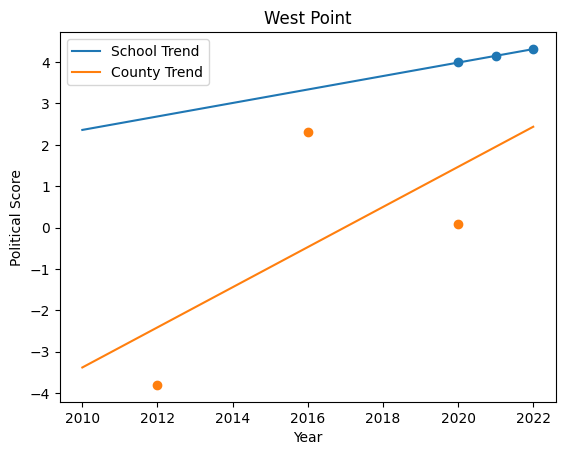

Hampton Virginia [-17.89279590646822, -15.767849121853894, nan]
Incomplete Information
Harris Texas [-0.034311387069207444, -5.184220554303413, -5.56895767839231]


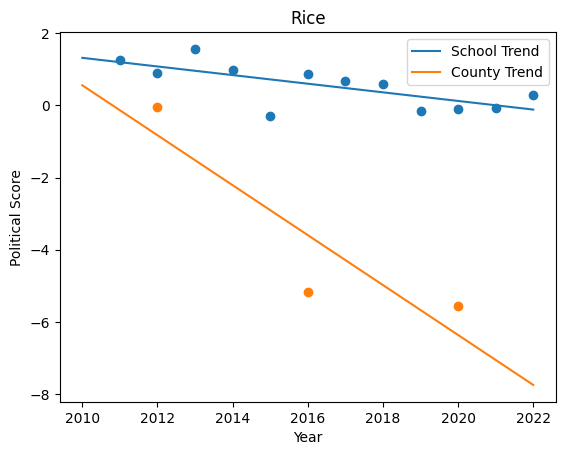

Fulton Georgia [-12.507220447934333, -17.453437832095396, -19.525001953277748]


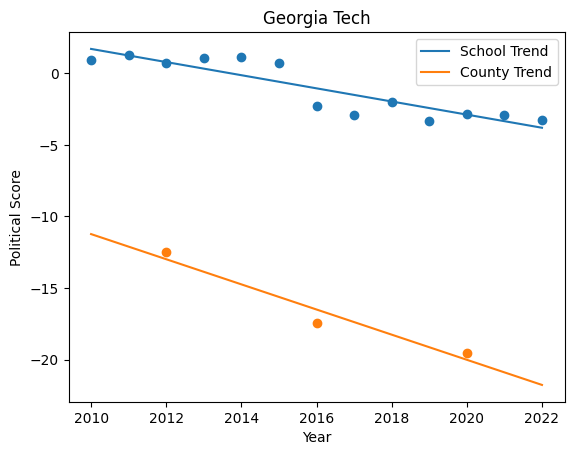

Orange North Carolina [-17.707883317781064, -21.099975707906243, -21.454357210083376]


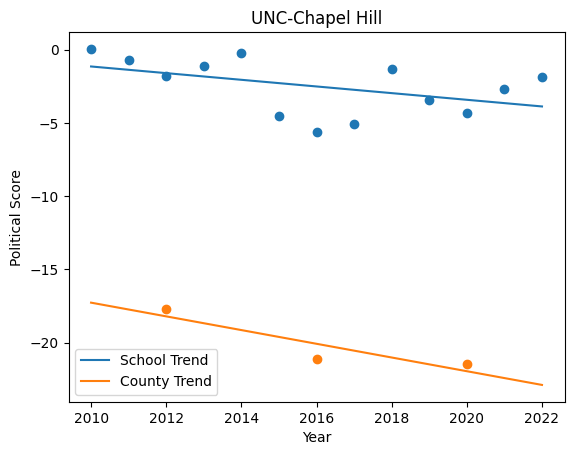

Durham North Carolina [-22.16996626420623, -24.990072628319904, -26.199284100948276]


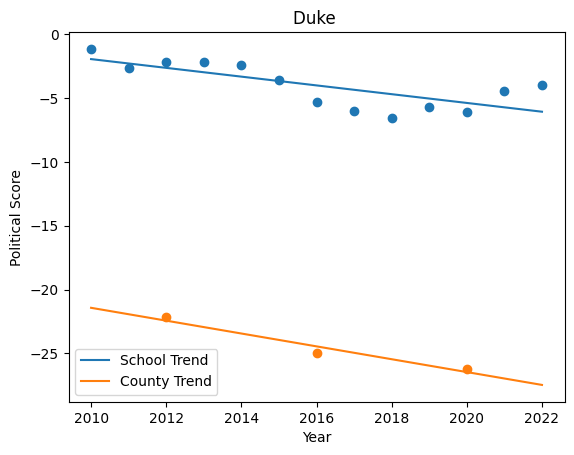

Davidson Tennessee [-7.803702327010178, -10.84518284119818, -13.49349927941492]


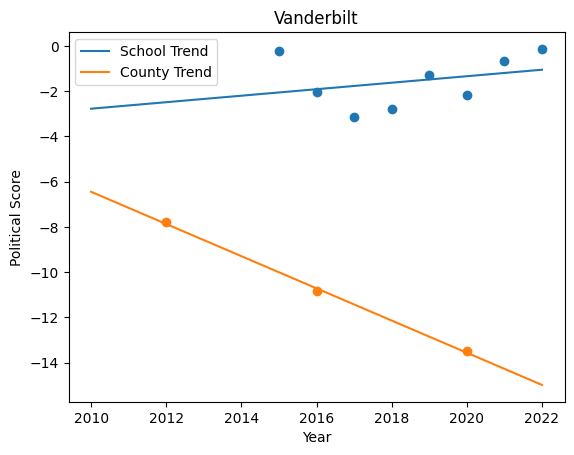

Albemarle Virginia [-5.03311258184779, -10.42929168098768, -14.07123745084504]


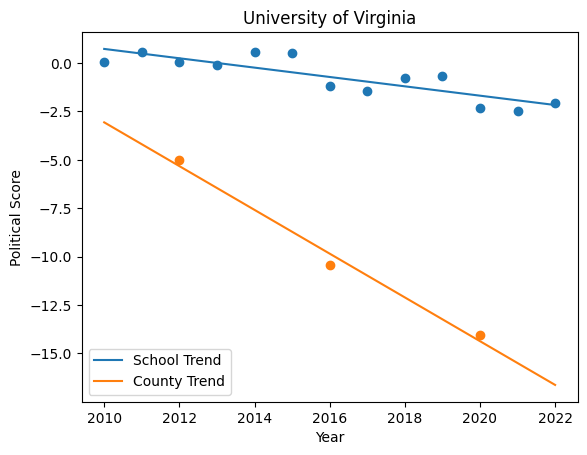

Cook Illinois [-20.73267657477749, -22.543935810588998, -21.125937438256678]


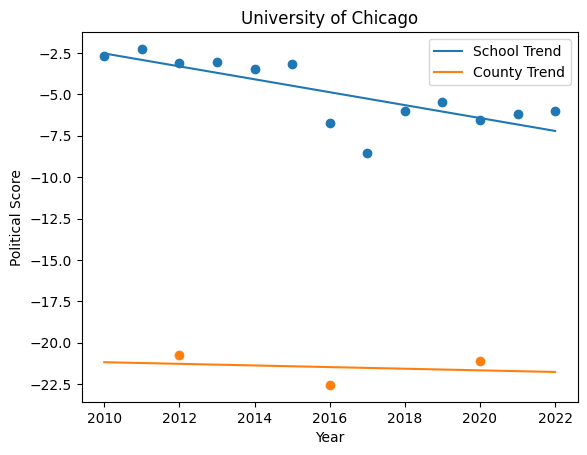

Cook Illinois [-20.73267657477749, -22.543935810588998, -21.125937438256678]


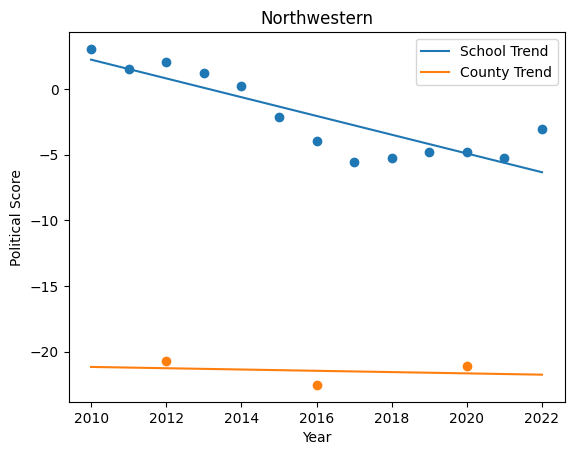

Jackson Missouri [3.5846741889871683, 4.9253498770783235, 1.7020843302700315]


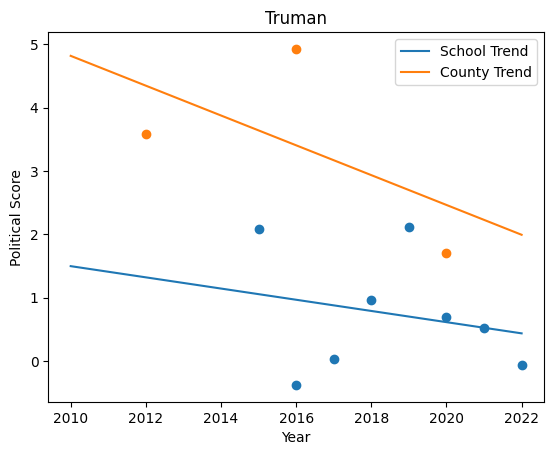

Poweshiek Iowa [-3.928421048693317, 2.7421946478773576, 5.662130171930839]


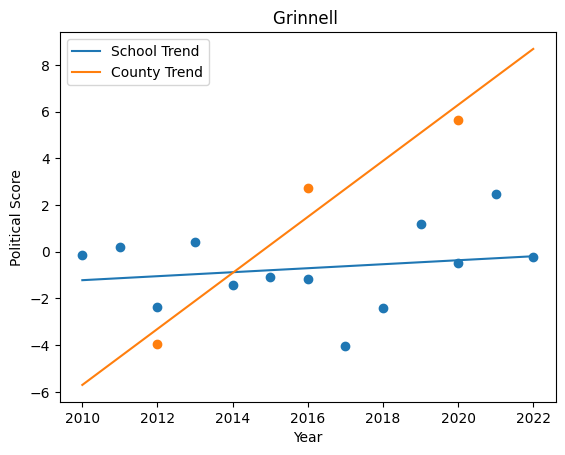

Knox Ohio [10.054670984199428, 16.046292740249488, 18.394228925920686]


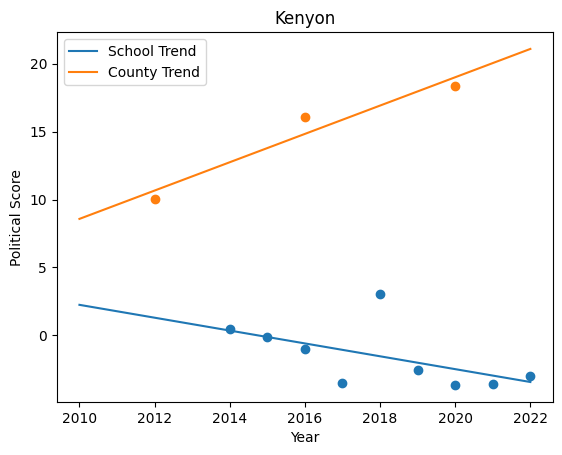

McLean Illinois [4.615409772884983, 0.5476545374149581, -1.6563067513785534]


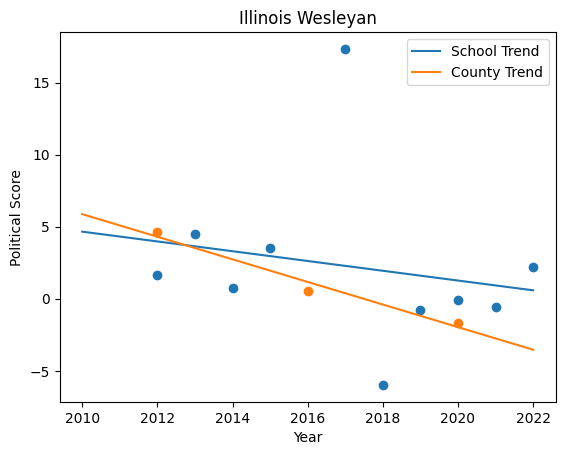

Washoe Nevada [-1.5551994888847684, -0.5244272517841352, -1.9001651081180793]


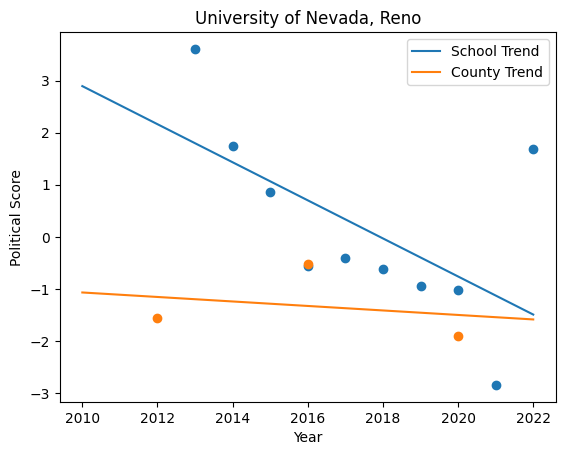

Champaign Illinois [-2.9581541363521535, -7.686493210843138, -9.615564103170467]


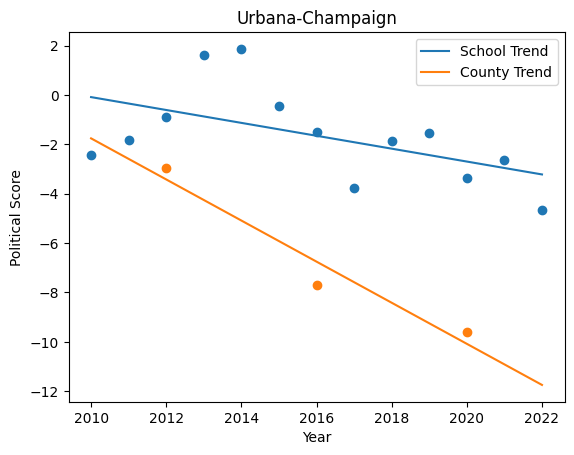

Hennepin Minnesota [-11.357999602812118, -14.670725627268709, -18.14796638462493]


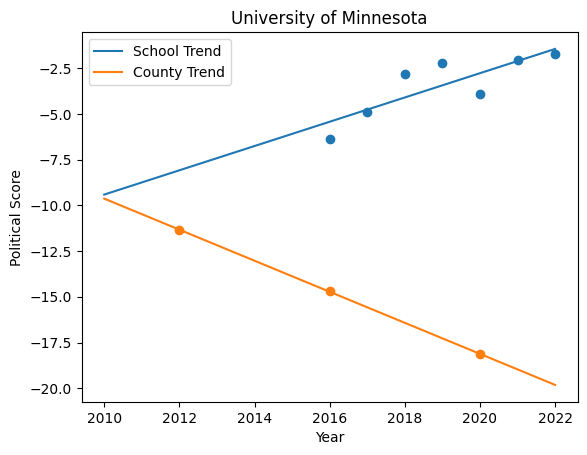

In [35]:
for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    biprt_x = []
    biprt_lst = []
    for year in range(2010, 2023):
        if pd.isna(rows[str(year)]):
            continue
        else:
            biprt_x.append(year)
            biprt_lst.append(rows[str(year)])
    
    if len(biprt_lst) < 3:
        continue
    
    schl = LinearRegression()
    schl.fit(np.expand_dims(np.array(biprt_x), axis=1), np.expand_dims(np.array(biprt_lst), axis=1))
    pred_line = [schl.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    elec_years = [2012, 2016, 2020]
    info = [pt * 42 for pt in get_county_info(rows['County'].upper(), rows['State'].upper())]
    
    print(rows['County'], rows['State'], info)
    
    if sum([1 if pd.isna(val) else 0 for val in info]) > 0:
        print('Incomplete Information')
        continue
    
    us = LinearRegression()
    us.fit(np.expand_dims(np.array(elec_years), axis=1), np.expand_dims(np.array(info), axis=1))
    pred_elec = [us.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    plt.Figure()
    plt.scatter(biprt_x, biprt_lst)
    plt.plot(range(2010, 2023), pred_line, label='School Trend')
    plt.scatter(elec_years, info)
    plt.plot(range(2010, 2023), pred_elec, label='County Trend')
    plt.legend()
    plt.title(rows['Name'])
    plt.xlabel('Year')
    plt.ylabel('Political Score')
    plt.show()

# Undergrad Size vs Polarity

In [36]:
college_data

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,State
0,region,name,publicprivate,tuition,population,acceptance,ranking,geo,male2female,college-type,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownership,County,State
1,us-west,Stanford,Private,"$57,692","7,761",4.34%,6,Suburban,49 : 51,Research,...,-6.244466,-5.684776,-7.151565,-6.981125,-5.677183,-1.537808,2008.189960,Independent,Santa Clara,California
2,us-west,UC Berkeley,Public,"$43,980","32,143",17.50%,49,Urban,46 : 54,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Alameda,California
3,us-west,Santa Clara,Private,"$58,017","5,895",52.00%,NaN,Suburban,53 : 47,Catholic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Santa Clara,California
4,us-west,Caltech,Private,"$58,479",901,6.70%,2,Suburban,65 : 35,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,California
5,us-west,USC,Private,"$63,468","20,790",21.10%,43,Urban,46 : 54,Research,...,-3.919732,-2.692837,-5.143249,-2.996033,-0.472082,-0.225776,452.264168,Independent,Los Angeles,California
6,us-west,University of Washington,Public,"$40,740","30,856",53.50%,NaN,Urban,45 : 55,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,King,Washington
7,us-west,Harvey Mudd College,Private,"$62,516",905,10%,28,Suburban,50 : 50,Science & Engineering,...,NaN,NaN,0.761180,0.151384,0.425327,NaN,NaN,Independent,Los Angeles,California
8,us-west,Pomona College,Private,"$59,238","1,764",6.60%,16,Suburban,45 : 55,Liberal Arts,...,-8.483771,-5.880843,-7.086419,-6.771482,NaN,-0.570280,1144.353493,Independent,Los Angeles,California
9,us-west,UCLA,Public,"$13,804","31,600",10.80%,35,Urban,44 : 56,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,California


29


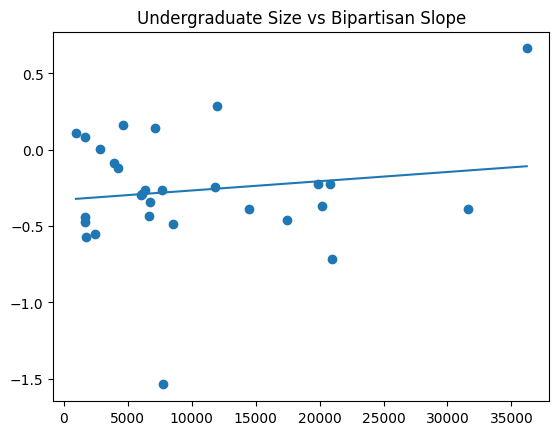

In [37]:
under_sz = []
bip_slp = []

for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    if not pd.isna(rows['Bipartisan Slope']):
        bip_slp.append(rows['Bipartisan Slope'])
        under_sz.append(int(rows['Undergraduate Population (2023)'].replace(',', '')))

sz_md = LinearRegression()
sz_md.fit(np.array(under_sz).reshape(len(under_sz),-1), np.array(bip_slp).reshape(len(bip_slp), -1))

pred_slp = [sz_md.predict(np.array([sz]).reshape(1,1))[0][0] for sz in np.arange(min(under_sz), max(under_sz)+1, 1)]

print(len(under_sz))

plt.Figure()
plt.plot(np.arange(min(under_sz), max(under_sz)+1, 1), pred_slp)
plt.scatter(under_sz, bip_slp)
plt.title('Undergraduate Size vs Bipartisan Slope')
plt.show()

In [42]:
import statsmodels.api as sm

df = pd.DataFrame({'undergraduate_size': under_sz,
                   'bipartisan_slope': bip_slp})

x = df['undergraduate_size']
y = df['bipartisan_slope']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       bipartisan_slope   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.5686
Date:                Sat, 22 Jul 2023   Prob (F-statistic):              0.457
Time:                        23:27:39   Log-Likelihood:                -12.656
No. Observations:                  29   AIC:                             29.31
Df Residuals:                      27   BIC:                             32.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3274      0

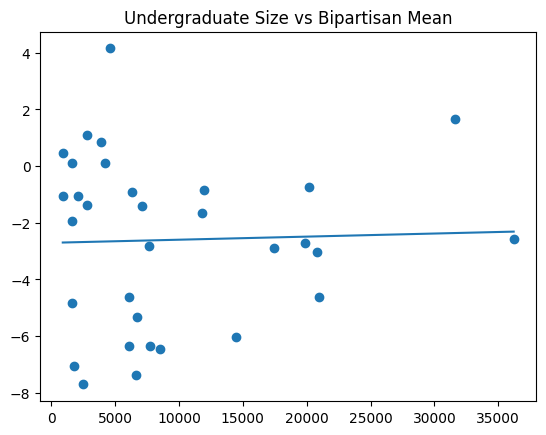

In [50]:
bip_mn = []
under_sz = []

for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    tmp = []
    for yr in range(2018, 2023):
        if pd.isna(rows[str(yr)]):
            continue
        
        tmp.append(rows[str(yr)])
        
    if len(tmp) > 2:
        bip_mn.append(np.mean(tmp))
        under_sz.append(int(rows['Undergraduate Population (2023)'].replace(',', '')))
        
sz_mn = LinearRegression()
sz_mn.fit(np.array(under_sz, dtype=np.float32).reshape(len(under_sz),-1), np.array(bip_mn, dtype=np.float32).reshape(len(bip_mn), -1))

pred_slp = [sz_mn.predict(np.array([sz]).reshape(1,1))[0][0] for sz in np.arange(min(under_sz), max(under_sz)+1, 1)]

# print(pred_slp)

plt.Figure()
plt.plot(np.arange(min(under_sz), max(under_sz)+1, 1), pred_slp)
plt.scatter(under_sz, bip_mn)
plt.title('Undergraduate Size vs Bipartisan Mean')
plt.show()

In [52]:
df = pd.DataFrame({'undergraduate_size': under_sz,
                   'bipartisan_mean': bip_mn})

x = df['undergraduate_size']
y = df['bipartisan_mean']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        bipartisan_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                   0.03257
Date:                Sat, 22 Jul 2023   Prob (F-statistic):              0.858
Time:                        23:34:48   Log-Likelihood:                -79.840
No. Observations:                  32   AIC:                             163.7
Df Residuals:                      30   BIC:                             166.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.7071      0

# Grouping by County

In [53]:
from collections import Counter

In [57]:
county_cnt = Counter(list([college_data['County'][i+1] +', ' + college_data['State'][i+1] for i in range(len(college_data['County'][1:]))]))
county_cnt

Counter({'Los Angeles, California': 5,
         'Middlesex, Massachusetts': 3,
         'Cook, Illinois': 3,
         'Santa Clara, California': 2,
         'New York, New York': 2,
         'Alameda, California': 1,
         'King, Washington': 1,
         'Utah, Utah': 1,
         'Delaware, Pennsylvania': 1,
         'Norfolk, Massachusetts': 1,
         'Grafton, New Hampshire': 1,
         'Suffolk, Massachusetts': 1,
         'Providence, Rhode Island': 1,
         'Middlesex, Connecticut': 1,
         'Addison, Vermont': 1,
         'New Haven, Connecticut': 1,
         'Orange, New York': 1,
         'Hampton, Virginia': 1,
         'Travis, Texas': 1,
         'Bedford, Virginia': 1,
         'DeKalb, Georgia': 1,
         'Harris, Texas': 1,
         'Fulton, Georgia': 1,
         'Orange, North Carolina': 1,
         'Durham, North Carolina': 1,
         'Davidson, Tennessee': 1,
         'Albemarle, Virginia': 1,
         'Jackson, Missouri': 1,
         'Poweshiek, Iowa': 

In [58]:
counties = set()

for county, cnt in county_cnt.items():
    if cnt >= 2:
        counties.add(county)
        
counties

{'Cook, Illinois',
 'Los Angeles, California',
 'Middlesex, Massachusetts',
 'New York, New York',
 'Santa Clara, California'}

In [59]:
def counties_get_school(county):
    return [rows['Name'] for index, rows in college_data.iterrows() if index != 0 and rows['County'] + ', ' + rows['State'] == county]

In [61]:
counties_get_school('Los Angeles, California')

['Caltech', 'USC', 'Harvey Mudd College', 'Pomona College', 'UCLA']

In [62]:
def get_school_info(schl):
    for index, rows in college_data.iterrows():
        if rows['Name'] == schl:
            bip_yr = []
            bip_val = []
            for yr in range(2010, 2023):
                if not pd.isna(rows[str(yr)]):
                    bip_yr.append(yr)
                    bip_val.append(rows[str(yr)])

            return len(bip_yr) > 0, bip_yr, bip_val
        
    return False, None, None

In [63]:
get_school_info('Stanford')

(True,
 [2010,
  2011,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019,
  2020,
  2021,
  2022],
 [-0.933991,
  -1.649278,
  -3.162174,
  -3.544305,
  -5.180576,
  -6.166527,
  -6.594643,
  -7.052272,
  -6.244466,
  -5.684776,
  -7.151565,
  -6.981125,
  -5.677183])

In [71]:
def group_counties(county):
    schls = counties_get_school(county)
    ct = county.split(', ')[0].upper()
    st = county.split(', ')[1].upper()
    
    plt.Figure()
    plt.title(f'{county} County')
    plt.xlabel('Year')
    plt.ylabel('Political Trends')
    for school in schls:
        has, yrs, vals = get_school_info(school)
        if not has:
            continue
        
        schl_reg = LinearRegression()
        schl_reg.fit(np.expand_dims(np.array(yrs), axis=1), np.expand_dims(np.array(vals), axis=1))
        
        plt.scatter(yrs, vals, s=10, alpha=0.5)
        
        pred_rg = np.arange(2010, 2023, 1)
        pred_rs = [schl_reg.predict(np.expand_dims(np.array([x]), axis=1))[0, 0] for x in pred_rg]
        
        plt.plot(pred_rg, pred_rs, label=f'{school} Trend')
    
    elec_years = [2012, 2016, 2020]
    
    print(ct, st)
    info = [pt * 42 for pt in get_county_info(ct, st)]
    
    
    
    us = LinearRegression()
    us.fit(np.expand_dims(np.array(elec_years), axis=1), np.expand_dims(np.array(info), axis=1))
    pred_elec = [us.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    plt.scatter(elec_years, info, s=10, alpha=0.5)
    plt.plot(range(2010, 2023), pred_elec, label='County Trend')
    
    plt.legend()
    return plt

In [72]:
'Los Angeles, California'.split(', ')

['Los Angeles', 'California']

LOS ANGELES CALIFORNIA


<module 'matplotlib.pyplot' from '/home/harry/.local/lib/python3.11/site-packages/matplotlib/pyplot.py'>

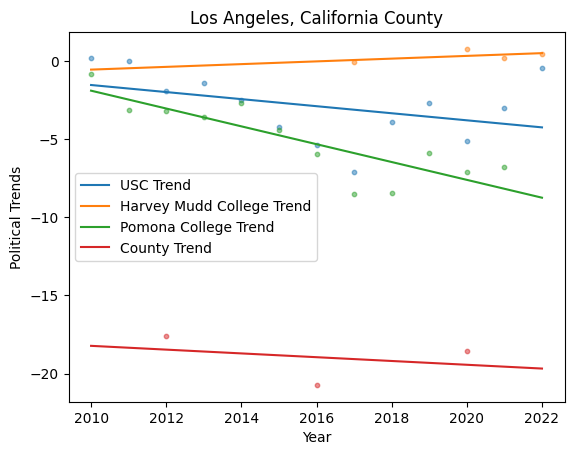

In [73]:
group_counties('Los Angeles, California')

SANTA CLARA CALIFORNIA


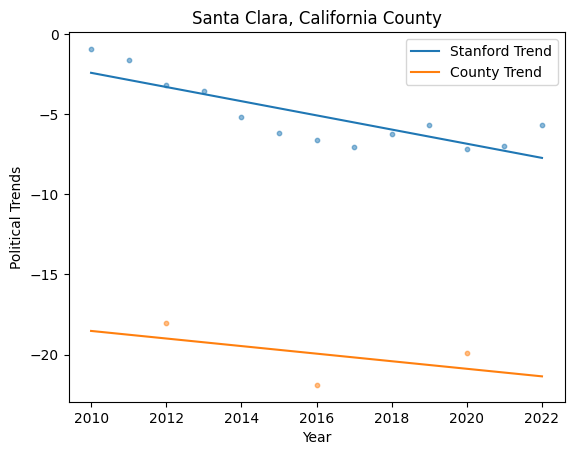

LOS ANGELES CALIFORNIA


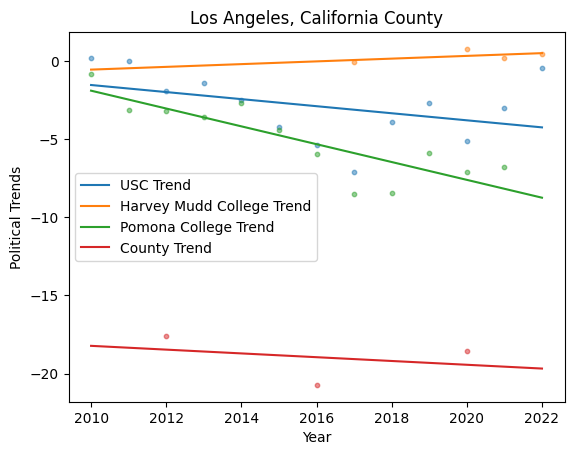

MIDDLESEX MASSACHUSETTS


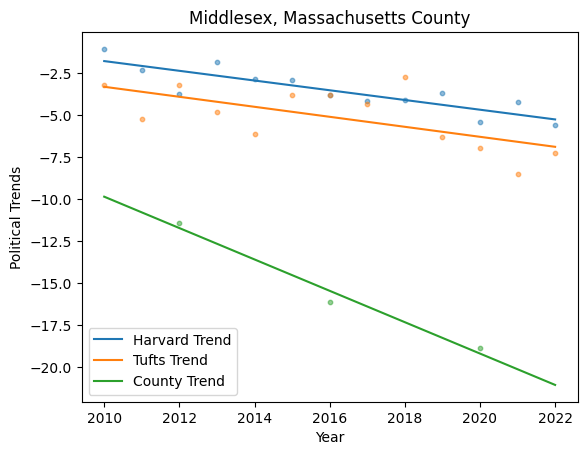

NEW YORK NEW YORK


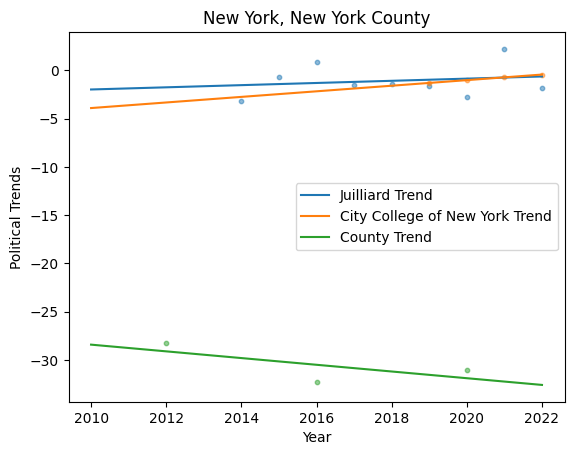

COOK ILLINOIS


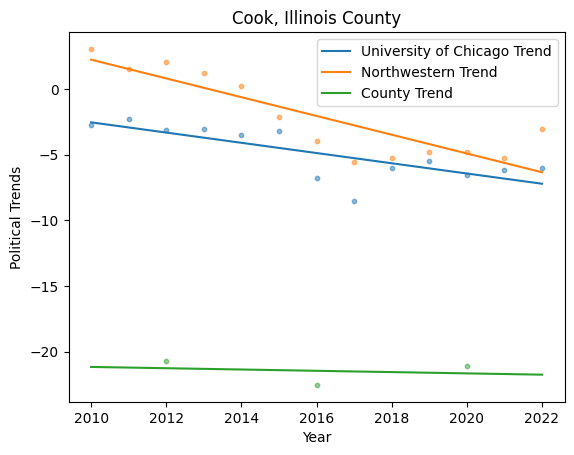

<Figure size 640x480 with 0 Axes>

In [74]:
for county in counties:
    plt = group_counties(county)
    plt.show()
    plt.clf()